In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b10','b25','b50','b75'],'fi':['targets','roi','brain']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_100000_1024_512_256_128_0001_CCE_10_1_0_0_1_0_e_e_0_1_0_basal_seg_data_norm_e_k5_b25_t1_0_42_n_native_08_0_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(878801, 92)
(878801, 3)
validation
(151459, 92)
(151459, 3)
test
(112754, 92)
(112754, 3)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 92)]              0         
                                                                 
 dense (Dense)               (None, 1024)              95232     
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 3)                 387       
                                                                 
Total params: 784643 (2.99 MB)
Trainable params: 784643 (2.99 M

In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000
9/9 [==============================] - 13s 827ms/step - loss: 1.1274 - STD: 0.1307 - MAE: 0.4309 - val_loss: 1.0758 - val_STD: 0.0506 - val_MAE: 0.4369
Epoch 2/10000
9/9 [==============================] - 1s 126ms/step - loss: 1.0835 - STD: 0.0446 - MAE: 0.4388 - val_loss: 1.0735 - val_STD: 0.0920 - val_MAE: 0.4304
Epoch 3/10000
9/9 [==============================] - 1s 123ms/step - loss: 1.0739 - STD: 0.0964 - MAE: 0.4292 - val_loss: 1.0648 - val_STD: 0.0618 - val_MAE: 0.4331
Epoch 4/10000
9/9 [==============================] - 1s 124ms/step - loss: 1.0568 - STD: 0.0597 - MAE: 0.4311 - val_loss: 1.0362 - val_STD: 0.0822 - val_MAE: 0.4227
Epoch 5/10000
9/9 [==============================] - 1s 120ms/step - loss: 1.0016 - STD: 0.1050 - MAE: 0.4092 - val_loss: 0.9572 - val_STD: 0.1332 - val_MAE: 0.3928
Epoch 6/10000
9/9 [==============================] - 1s 122ms/step - loss: 0.9243 - STD: 0.1765 - MAE: 0.3718 - val_loss: 0.9366 - val_STD: 0.2184 - val_MAE: 0.3579
Epoch 7/1

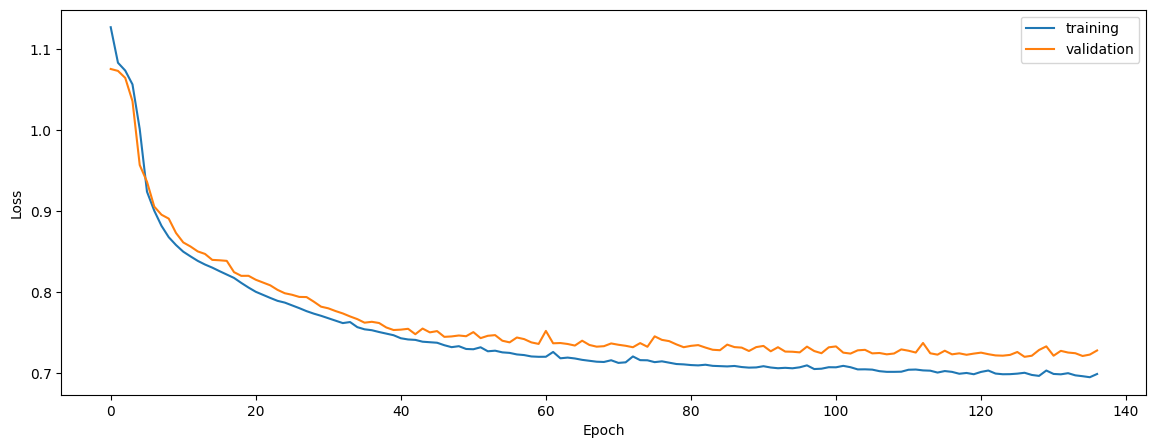

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced
0.6913191951306382
0.677371433853386
0.6991681004665024


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original
0.7320585933794935
0.7009466730232241
0.731593146862822


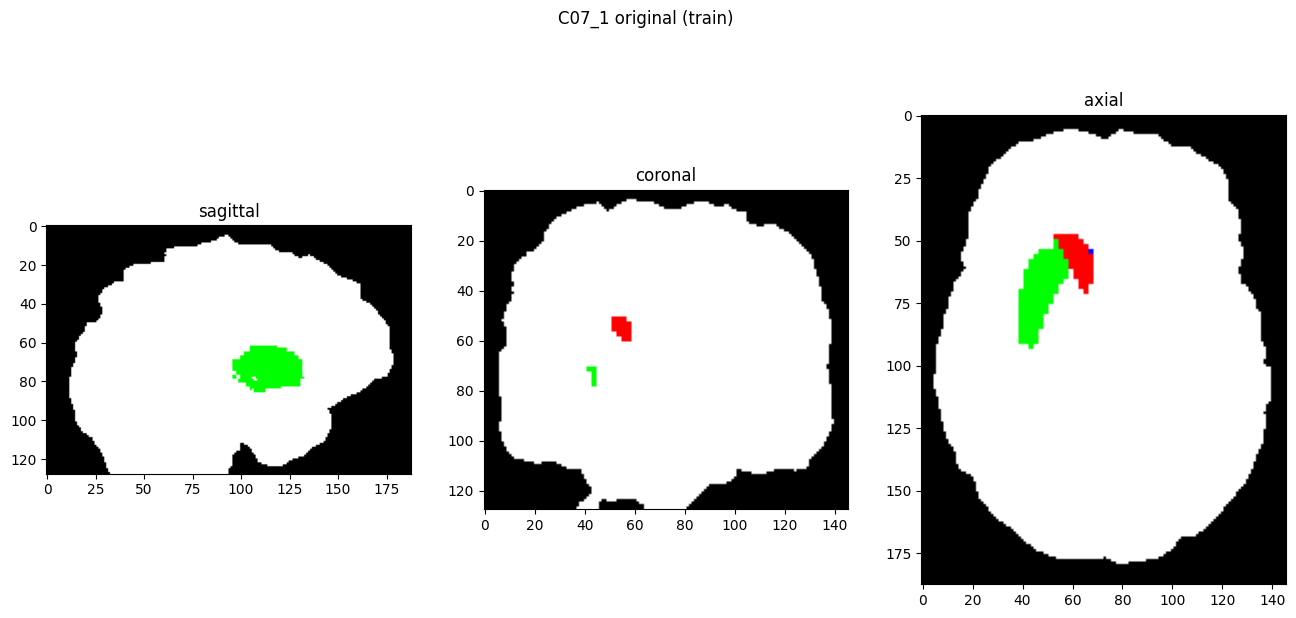

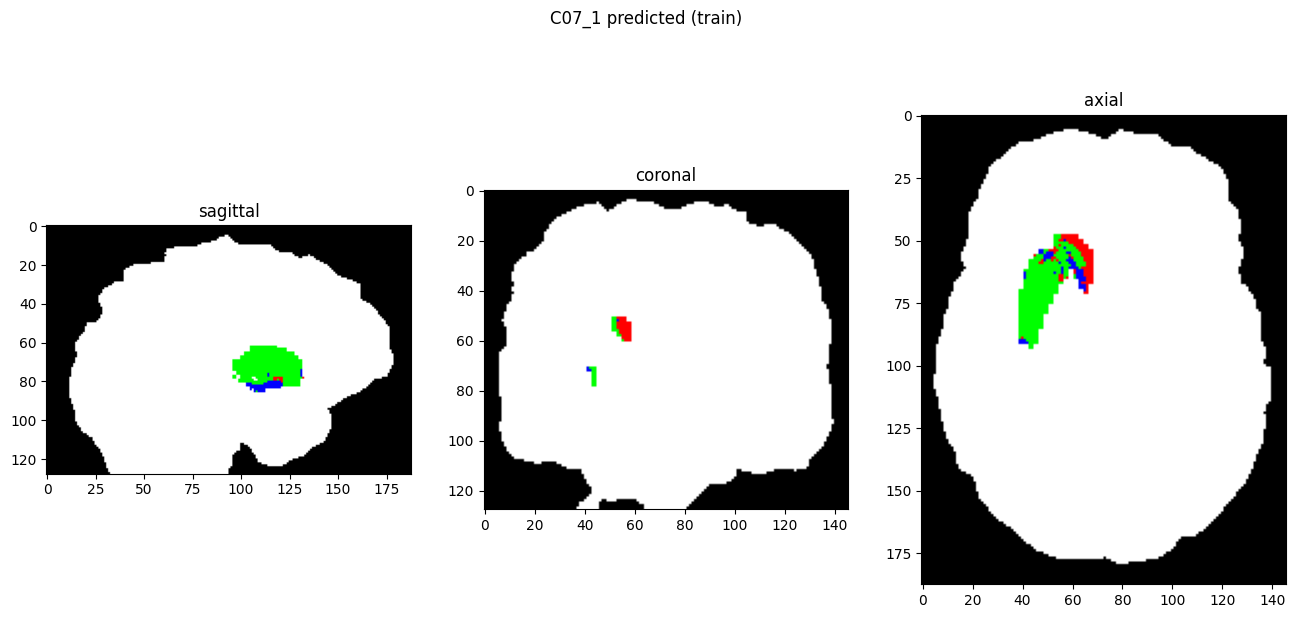

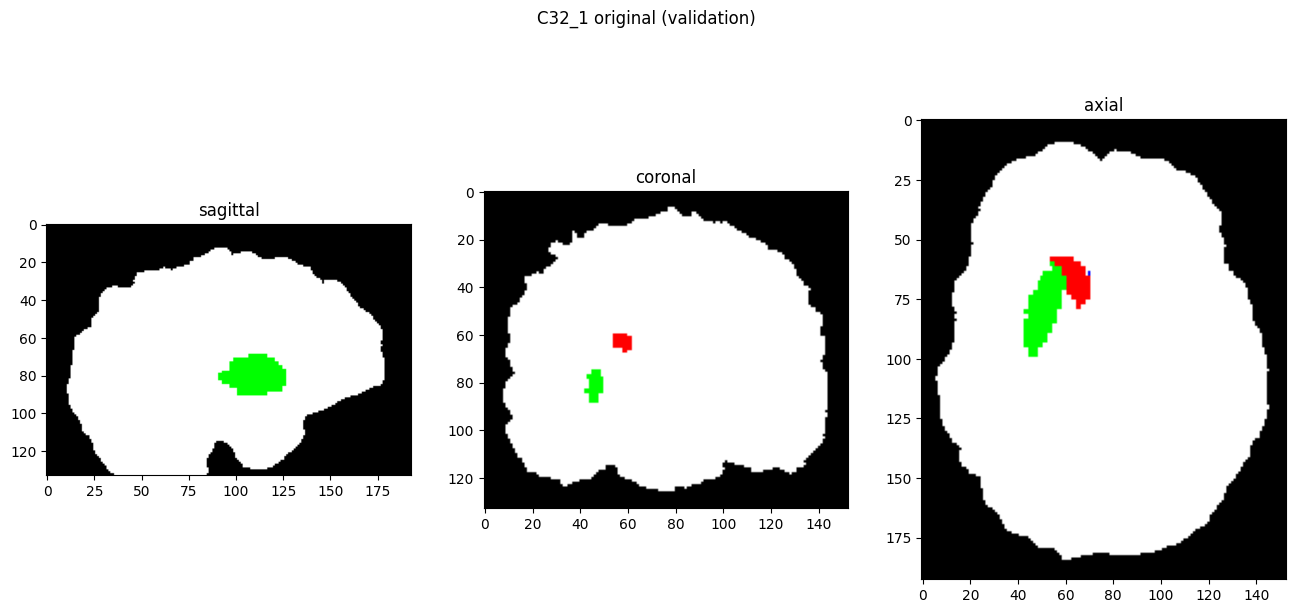

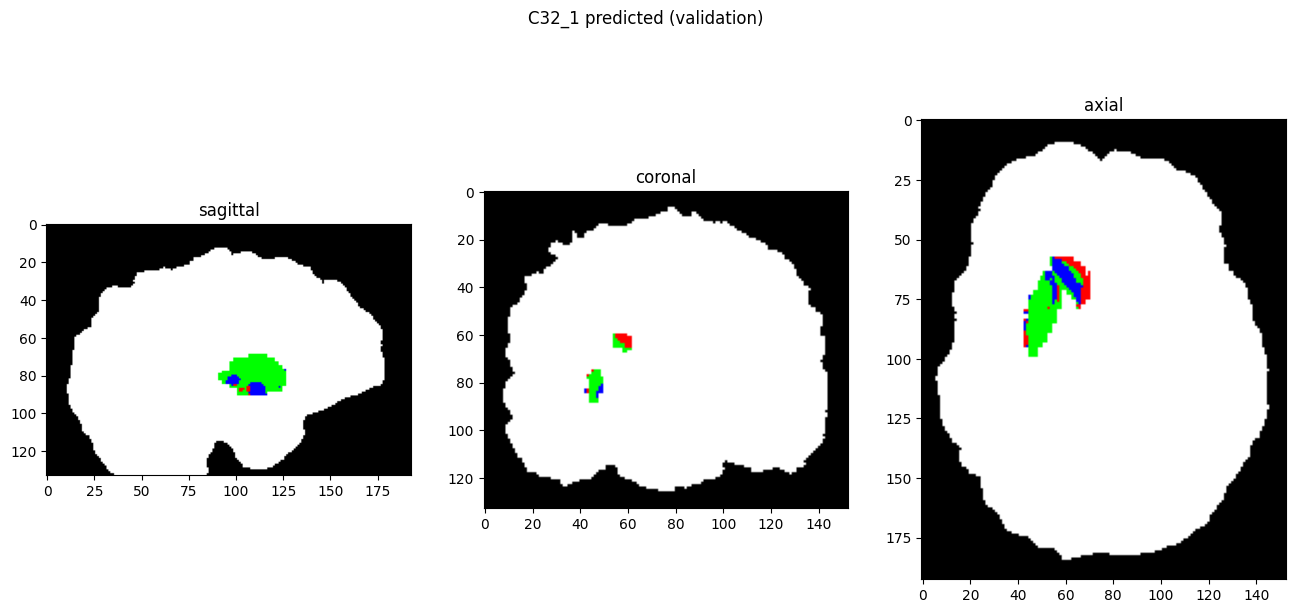

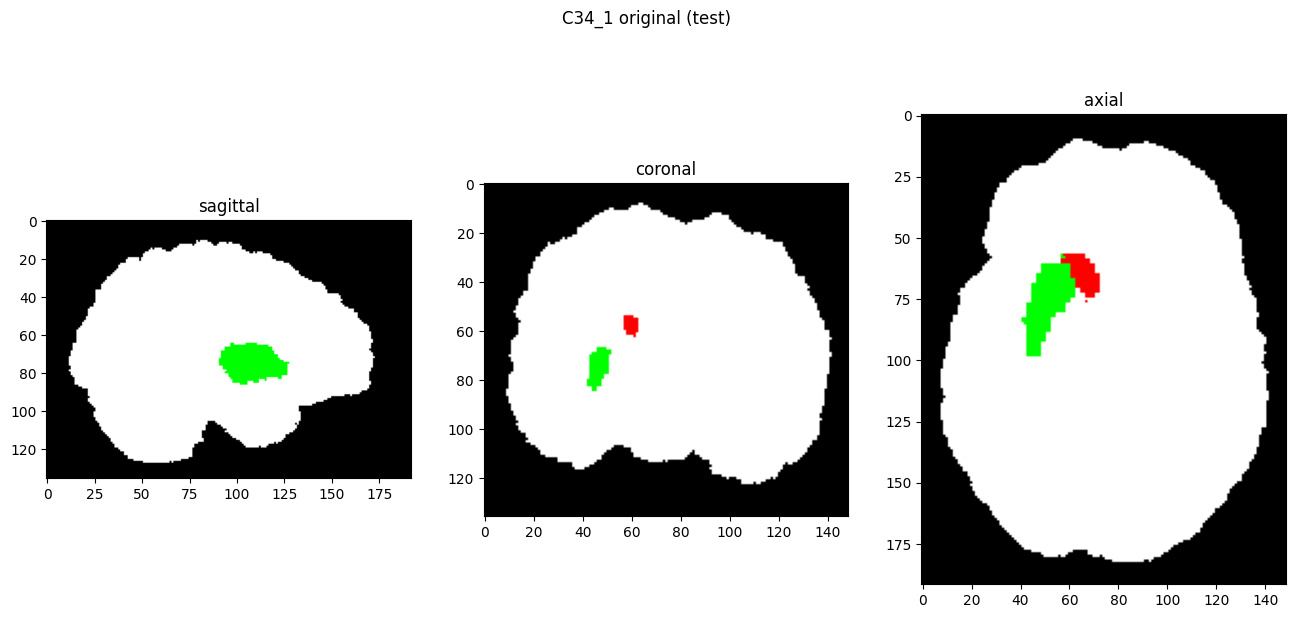

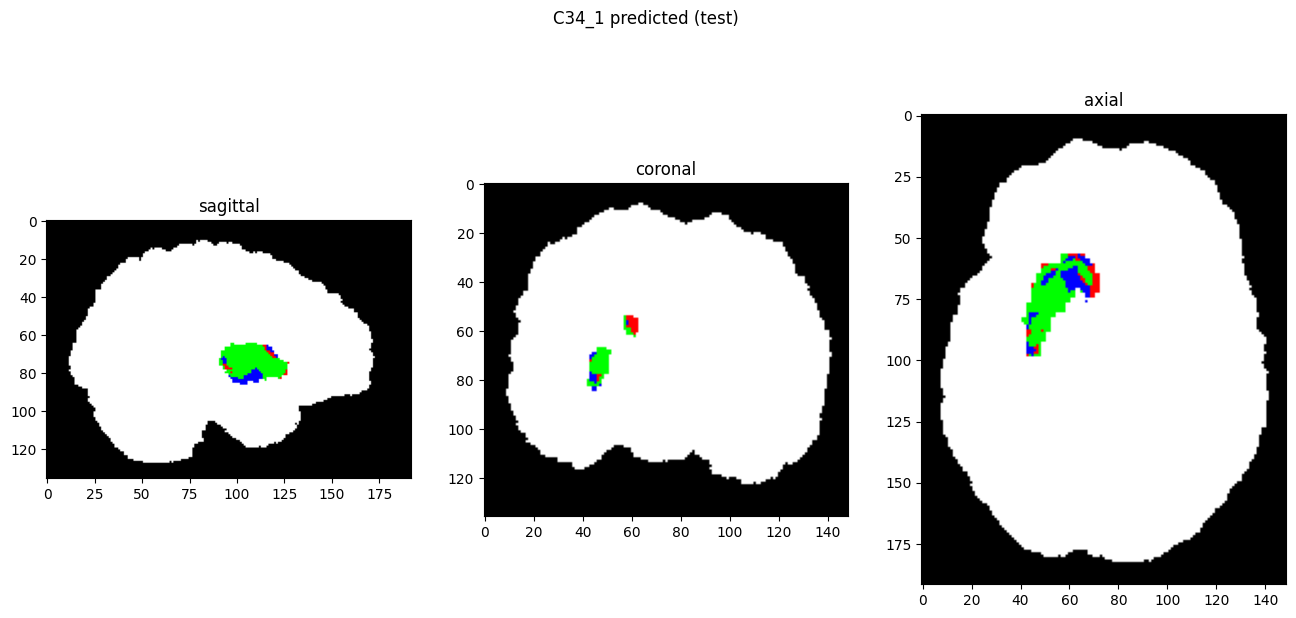

In [9]:
showResults(model, gen, threshold=0)